In [1]:
# Import Libraries
import sys

import numpy as np
import pandas as pd
import scipy
import sklearn.manifold

from matplotlib import pyplot as plt

import torch
from torch.utils.data import TensorDataset
from torch import nn

source = "../source"
sys.path.append(source)

from preprocessing import Direct
from compilation import Compiler, ScalarTracker
from activations import get_activations
import publication
import models

device = torch.device("cpu")

plot_path = "./plots/orthogonal/"

save = True

/tmp/ipykernel_28574/1396530905.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def blobs(device, N_datapoints=(10, 10), N_pixels=(10, 10)):
    """2d dataset of gaussian blobs."""
    x, y = np.linspace(-1, 1, N_pixels[0]), np.linspace(-1, 1, N_pixels[1])
    x, y = np.meshgrid(x, y)

    ## Generate blobs
    inputs, outputs_x, outputs_y = [], [], []
    for mu_x in np.linspace(-1, 1, N_datapoints[0]):
        for mu_y in np.linspace(-1, 1, N_datapoints[1]):
            gaussian = np.exp(-((x - mu_x) ** 2 + (y - mu_y) ** 2) / 2)
            gaussian = gaussian / np.sum(gaussian)
            inputs.append(gaussian.ravel())
            outputs_x.append(mu_x)
            outputs_y.append(mu_y)
    inputs = torch.tensor(inputs, device=device, dtype=torch.float32)
    outputs_x = torch.tensor(outputs_x, device=device, dtype=torch.float32)
    outputs_y = torch.tensor(outputs_y, device=device, dtype=torch.float32)

    ## Add context variable
    inputs_x = torch.concatenate(
        (inputs, torch.ones((inputs.shape[0], 1)), torch.zeros((inputs.shape[0], 1))),
        axis=1,
    )
    inputs_y = torch.concatenate(
        (inputs, torch.zeros((inputs.shape[0], 1)), torch.ones((inputs.shape[0], 1))),
        axis=1,
    )
    inputs = torch.concatenate((inputs_x, inputs_y))
    outputs = torch.concatenate((outputs_x, outputs_y))

    dataset = TensorDataset(inputs, outputs)

    return dataset

In [3]:
# Load the data
encoding = Direct()
pixels = 5
N_data = 30
input_size = pixels * pixels

data = blobs(device, N_datapoints=(N_data, N_data), N_pixels=(pixels, pixels))

train_datasets = [data]
tracked_datasets = train_datasets

analyzed_data = data
labels = data.tensors[1]
inputs = data.tensors[0]
context = inputs[:, -1]
feature_x = np.concatenate(
    (labels[: int(len(inputs) / 2)], labels[: int(len(inputs) / 2)])
)
feature_y = np.concatenate(
    (labels[int(len(inputs) / 2) :], labels[int(len(inputs) / 2) :])
)

/tmp/ipykernel_28574/1188382806.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1705951072540/work/torch/csrc/utils/tensor_new.cpp:261.)
  inputs = torch.tensor(inputs, device=device, dtype=torch.float32)


In [4]:
## Load settings
settings = "high_init"

(
    model_type,
    nonlinearity,
    gain,
    lr,
    P,
    L,
    n_epochs,
    hidden_layer,
    dx2,
    dy2,
    in_dim,
    out_dim,
) = (
    pd.read_csv("model_settings/orthogonal.txt", sep=" ", header=0)
    .loc[settings]
    .to_numpy()
)
model_type = getattr(models, model_type)
nonlinearity = getattr(torch.nn.functional, nonlinearity)

In [5]:
## Instantiate model
model = model_type(
    encoding=encoding,
    input_size=data.tensors[0].shape[1],
    output_size=1,
    hidden_dim=P,
    n_hid_layers=L,
    device=device,
    init_std=gain,
)

In [6]:
## Setup compiler
criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
}

In [7]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=64
)

Training: 100%|██████████| 750/750 [00:45<00:00, 16.66steps/s, train_loss=0.00015, val_loss=0.00017]


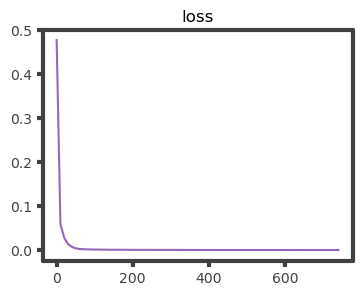

In [8]:
## Plot loss
mod = 10
query = f"Epoch % {mod} == 0"
loss = compiler.trackers["loss"].get_trace()
train_loss = loss.query("Dataset==0").groupby("Epoch").mean().query(query)

fig = plt.figure(figsize=(4, 3))
plt.plot(0, 0)
plt.plot(0, 0)
plt.plot(0, 0)
plt.plot(0, 0)
plt.plot(train_loss)
plt.title("loss")
publication.pub_show()

In [9]:
## Apply dimensionality reduction
h = get_activations(train_datasets, lambda x: model(x)[1][hidden_layer], encoding)
x = inputs

h_red = sklearn.manifold.MDS(n_components=3).fit_transform(h)

# # Rotate
# R = scipy.spatial.transform.Rotation(
#     (np.pi / 2, np.pi / 4, np.pi / 4, np.pi / 4)
# ).as_matrix()
# h_red = h_red @ R.T

In [10]:
def plot(X, dims, labels, save_path=None):
    X = X[:, [dims[0], dims[1]]]

    fig = plt.figure(figsize=(2, 2))

    for output in np.unique(labels):
        x_red_digit = X[labels == output]
        plt.scatter(x_red_digit[:, 0], x_red_digit[:, 1])

    plt.gca().spines[["right", "top", "left", "bottom"]].set_visible(False)
    plt.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        right=False,
        top=False,
        labelbottom=False,
        labelleft=False,
    )
    plt.xlabel(f"MDS dim {dims[0]+1}")
    plt.ylabel(f"MDS dim {dims[1]+1}")

    if save_path:
        publication.pub_show(save_path=save_path)
    else:
        publication.pub_show()

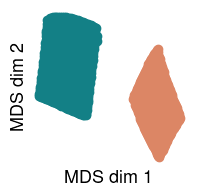

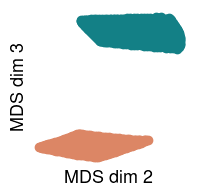

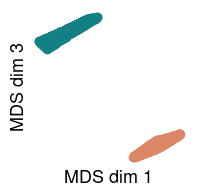

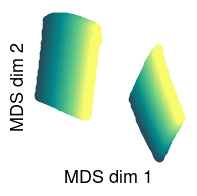

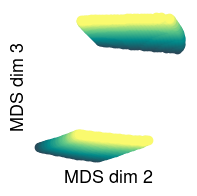

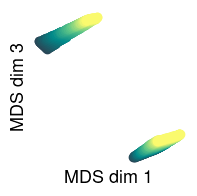

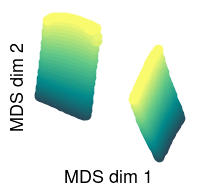

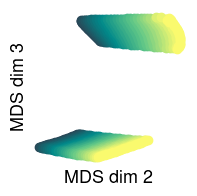

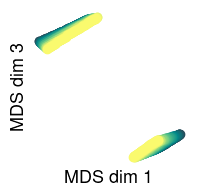

In [11]:
## Plot context
publication.set_color_mixed()
plot(
    h_red,
    (0, 1),
    context,
    save_path=plot_path + settings + "_context_dim_1,2",
)
plot(
    h_red,
    (1, 2),
    context,
    save_path=plot_path + settings + "_context_dim_2,3",
)
plot(
    h_red,
    (0, 2),
    context,
    save_path=plot_path + settings + "_context_dim_1,3",
)

## Plot feature 1
publication.set_color_gradient(index=2, N=len(set(feature_x)))
plot(
    h_red,
    (0, 1),
    feature_x,
    save_path=plot_path + settings + "_feature_x_dim_1,2",
)
plot(
    h_red,
    (1, 2),
    feature_x,
    save_path=plot_path + settings + "_feature_x_dim_2,3",
)
plot(
    h_red,
    (0, 2),
    feature_x,
    save_path=plot_path + settings + "_feature_x_dim_1,3",
)

## Plot feature 2
plot(
    h_red,
    (0, 1),
    feature_y,
    save_path=plot_path + settings + "_feature_y_dim_1,2",
)
plot(
    h_red,
    (1, 2),
    feature_y,
    save_path=plot_path + settings + "_feature_y_dim_2,3",
)
plot(
    h_red,
    (0, 2),
    feature_y,
    save_path=plot_path + settings + "_feature_y_dim_1,3",
)